# 多输入通道和多输出通道

前面两节里我们用到的输入和输出都是二维数组，但真实数据的维度经常更高。例如，彩色图像在高和宽2个维度外还有RGB（红、绿、蓝）3个颜色通道。假设彩色图像的高和宽分别是$h$和$w$（像素），那么它可以表示为一个$3\times h\times w$的多维数组。我们将大小为3的这一维称为通道（channel）维。本节我们将介绍含多个输入通道或多个输出通道的卷积核。



## 多输入通道

当输入数据含多个通道时，我们需要构造一个输入通道数与输入数据的通道数相同的卷积核，从而能够与含多通道的输入数据做互相关运算。

假设输入数据的通道数为$c_i$，那么卷积核的输入通道数同样为$c_i$。

设卷积核窗口形状为$k_h\times k_w$。

1.当$c_i=1$时，我们知道卷积核只包含一个形状为$k_h\times k_w$的二维数组。

2.当$c_i > 1$时，我们将会为每个输入通道各分配一个形状为$k_h\times k_w$的核数组。把这$c_i$个数组在输入通道维上连结，即得到一个形状为$c_i\times k_h\times k_w$的卷积核。

由于输入和卷积核各有$c_i$个通道，我们可以在各个通道上对输入的二维数组和卷积核的二维核数组做互相关运算，再将这$c_i$个互相关运算的二维输出按通道相加，得到一个二维数组。这就是含多个通道的输入数据与多输入通道的卷积核做二维互相关运算的输出。

图5.4展示了含2个输入通道的二维互相关计算的例子。在每个通道上，二维输入数组与二维核数组做互相关运算，再按通道相加即得到输出。图5.4中阴影部分为第一个输出元素及其计算所使用的输入和核数组元素：$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$。

![含2个输入通道的互相关计算](../img/conv_multi_in.svg)


接下来我们实现含多个输入通道的互相关运算。我们只需要对每个通道做互相关运算，

然后通过`add_n`函数来进行累加。

In [2]:
import d2lzh as d2l
from mxnet import nd

def corr2d_multi_in(X, K):
    # 首先沿着X和K的第0维（通道维）遍历。
    # 然后使用*将结果列表变成add_n函数的位置参数（positional argument）来进行相加
    return nd.add_n(*[d2l.corr2d(x, k) for x, k in zip(X, K)])

我们可以构造图5.4中的输入数组`X`、核数组`K`来验证互相关运算的输出。

In [3]:
X = nd.array([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = nd.array([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])

corr2d_multi_in(X, K)


[[ 56.  72.]
 [104. 120.]]
<NDArray 2x2 @cpu(0)>

## 多输出通道

当输入通道有多个时，因为我们对各个通道的结果做了累加，所以不论输入通道数是多少，输出通道数总是为1。

设卷积核输入通道数和输出通道数分别为$c_i$和$c_o$，高和宽分别为$k_h$和$k_w$。如果希望得到含多个通道的输出，我们可以为每个输出通道分别创建形状为$c_i\times k_h\times k_w$的核数组。将它们在输出通道维上连结，卷积核的形状即$c_o\times c_i\times k_h\times k_w$。在做互相关运算时，每个输出通道上的结果由卷积核在该输出通道上的核数组与整个输入数组计算而来。
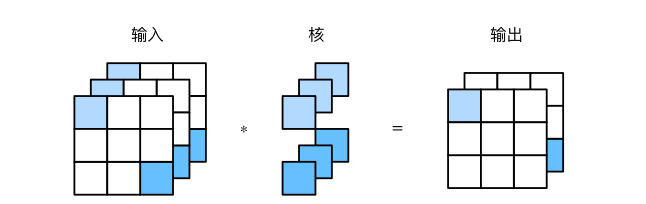

下面我们实现一个互相关运算函数来计算多个通道的输出。

In [4]:
def corr2d_multi_in_out(X, K):
    # 对K的第0维遍历，每次同输入X做互相关计算。所有结果使用stack函数合并在一起。stack增加一维
    return nd.stack(*[corr2d_multi_in(X, k) for k in K])

我们将核数组`K`同`K+1`（`K`中每个元素加一）和`K+2`连结在一起来构造一个输出通道数为3的卷积核。

In [5]:
K = nd.stack(K, K + 1, K + 2)
K.shape

(3, 2, 2, 2)

下面我们对输入数组`X`与核数组`K`做互相关运算。此时的输出含有3个通道。其中第一个通道的结果与之前输入数组`X`与多输入通道、单输出通道核的计算结果一致。

In [6]:
corr2d_multi_in_out(X, K)


[[[ 56.  72.]
  [104. 120.]]

 [[ 76. 100.]
  [148. 172.]]

 [[ 96. 128.]
  [192. 224.]]]
<NDArray 3x2x2 @cpu(0)>

## $1\times 1$卷积层

最后我们讨论卷积窗口形状为$1\times 1$（$k_h=k_w=1$）的多通道卷积层。我们通常称之为$1\times 1$卷积层，并将其中的卷积运算称为$1\times 1$卷积。因为使用了最小窗口，$1\times 1$卷积失去了卷积层可以识别高和宽维度上相邻元素构成的模式的功能。实际上，$1\times 1$卷积的主要计算发生在通道维上。图5.5展示了使用输入通道数为3、输出通道数为2的$1\times 1$卷积核的互相关计算。值得注意的是，输入和输出具有相同的高和宽。输出中的每个元素来自输入中在高和宽上相同位置的元素在不同通道之间的按权重累加。假设我们将通道维当作特征维，将高和宽维度上的元素当成数据样本，那么$1\times 1$卷积层的作用与全连接层等价。

![使用输入通道数为3、输出通道数为2的$1\times 1$卷积核的互相关计算。输入和输出具有相同的高和宽](../img/conv_1x1.svg)

下面我们使用全连接层中的矩阵乘法来实现$1\times 1$卷积。这里需要在矩阵乘法运算前后对数据形状做一些调整。

In [7]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = nd.dot(K, X)  # 全连接层的矩阵乘法
    return Y.reshape((c_o, h, w))

经验证，做$1\times 1$卷积时，以上函数与之前实现的互相关运算函数`corr2d_multi_in_out`等价。

In [8]:
X = nd.random.uniform(shape=(3, 3, 3))
K = nd.random.uniform(shape=(2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

# P是一个矩阵，P.norm 是它的L2范数，如果运行程序显示的结果例如 ‘[12]’，所以需要asscalar 转换为 ‘12’。即把向量转化成标量。
(Y1 - Y2).norm().asscalar() < 1e-6

True

在之后的模型里我们将会看到$1\times 1$卷积层被当作保持高和宽维度形状不变的全连接层使用。于是，我们可以通过调整网络层之间的通道数来控制模型复杂度。


## 小结

* 使用多通道可以拓展卷积层的模型参数。
* 假设将通道维当作特征维，将高和宽维度上的元素当成数据样本，那么$1\times 1$卷积层的作用与全连接层等价。
* $1\times 1$卷积层通常用来调整网络层之间的通道数，并控制模型复杂度。


## 练习

* 假设输入形状为$c_i\times h\times w$，且使用形状为$c_o\times c_i\times k_h\times k_w$、填充为$(p_h, p_w)$、步幅为$(s_h, s_w)$的卷积核。那么这个卷积层的前向计算分别需要多少次乘法和加法？
* 翻倍输入通道数$c_i$和输出通道数$c_o$会增加多少倍计算？翻倍填充呢？
* 如果卷积核的高和宽$k_h=k_w=1$，能减少多少计算？
* 本节最后一个例子中的变量`Y1`和`Y2`完全一致吗？原因是什么？
* 当卷积窗口不为$1\times 1$时，如何用矩阵乘法实现卷积计算？




## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/6405)

![](../img/qr_channels.svg)